In [1]:
# ===== COPY FROM https://github.com/OGGM/oggm-edu-notebooks/blob/master/oggm-tuto/dem_comparison.ipynb =====

In [2]:
# The RGI Id of the glaciers you want to look for
# Use the original shapefiles or the GLIMS viewer to check for the ID: https://www.glims.org/maps/glims
rgi_id = 'RGI60-11.00897'

# The default is to test for all sources available for this glacier
# Set to a list of source names to override this
sources = None
# Where to write the plots. Default is in the current working directory
plot_dir = ''
# The RGI version to use
# V62 is an unofficial modification of V6 with only minor, backwards compatible modifications
prepro_rgi_version = 62
# Size of the map around the glacier. Currently only 10 is available
prepro_border = 10
# Degree of processing level.  Currently only 1 is available.
from_prepro_level = 1

In [3]:
# The sources can be given as parameters
if sources is not None and isinstance(sources, str):
    sources = sources.split(',')

In [4]:
# Plotting directory as well
if not plot_dir:
    plot_dir = './' + rgi_id
import os
plot_dir = os.path.abspath(plot_dir)

In [5]:

import pandas as pd
import numpy as np
from oggm import cfg, utils, workflow, tasks, graphics, GlacierDirectory
import xarray as xr
import geopandas as gpd
import salem
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import itertools

from oggm.utils import DEM_SOURCES
from oggm.workflow import init_glacier_regions

In [6]:
# Make sure the plot directory exists
utils.mkdir(plot_dir);
# Use OGGM to download the data
cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = '/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/'
# cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-DEMS', reset=True)
cfg.PARAMS['use_intersects'] = False

In [7]:
print('\n\nDOWNLOAD ALL THE DEMS FOR A GIVEN REGION\n\n')

# URL of the preprocessed GDirs
gdir_url = 'https://cluster.klima.uni-bremen.de/data/gdirs/dems_v0/'

# Hack to download all glaciers at once
shp = gpd.read_file(utils.get_rgi_region_file('11'))
# Hack to download only a subset
# shp = shp.iloc[:10] 

# We use OGGM to download the data
# gdir = init_glacier_regions([rgiid], from_prepro_level=1, prepro_border=10, 
#                             prepro_rgi_version='62', prepro_base_url=gdir_url)
gdirs = init_glacier_regions(shp, from_prepro_level=1, prepro_border=10, 
                             prepro_rgi_version='62', prepro_base_url=gdir_url)



DOWNLOAD ALL THE DEMS FOR A GIVEN REGION




RuntimeError: GlacierDirectory /Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01000 does not exist!

In [8]:
# This SHOULD no do anything, just checking that the directories are - but it does somthing as of today
# gdirs = init_glacier_regions(shp)

In [9]:
gdir = gdirs[0]

NameError: name 'gdirs' is not defined

In [26]:
(gdir.rgi_area_m2,
gdir.rgi_id,
gdir.rgi_date,
gdir.is_icecap,
gdir.get_filepath('outlines'))

(122000.0,
 'RGI60-11.00001',
 2003,
 False,
 '/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/outlines.shp')

In [27]:
from oggm import graphics

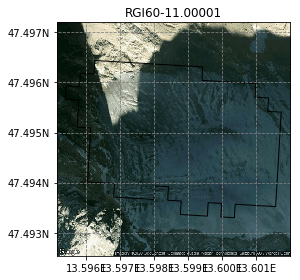

In [28]:
graphics.plot_googlemap(gdir)

In [29]:
if sources is None:
    sources = [src for src in os.listdir(gdir.dir) if src in utils.DEM_SOURCES]

In [30]:
sources

['AW3D30', 'MAPZEN', 'ASTER', 'TANDEM', 'DEM3', 'SRTM']

In [31]:
print('RGI ID:', rgi_id)
print('Available DEM sources:', sources)
print('Plotting directory:', plot_dir)
print('Glacier directory:', gdir.dir)

RGI ID: RGI60-11.00897
Available DEM sources: ['AW3D30', 'MAPZEN', 'ASTER', 'TANDEM', 'DEM3', 'SRTM']
Plotting directory: /Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/RGI60-11.00897
Glacier directory: /Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001


In [32]:
# We use xarray to store the data
ods = xr.Dataset()
for src in sources:
    demfile = os.path.join(gdir.dir, src) + '/dem.tif'
    print(demfile)
    with xr.open_rasterio(demfile) as ds:
        data = ds.sel(band=1).load() * 1.
        ods[src] = data.where(data > -100, np.NaN)
    
    sy, sx = np.gradient(ods[src], gdir.grid.dx, gdir.grid.dx)
    ods[src + '_slope'] = ('y', 'x'),  np.arctan(np.sqrt(sy**2 + sx**2))

with xr.open_rasterio(gdir.get_filepath('glacier_mask')) as ds:
    ods['mask'] = ds.sel(band=1).load()

/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/AW3D30/dem.tif
/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/MAPZEN/dem.tif
/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/ASTER/dem.tif
/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/TANDEM/dem.tif
/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/DEM3/dem.tif
/Users/davidrounce/Documents/Dave_Rounce/oggm_dems/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00001/SRTM/dem.tif


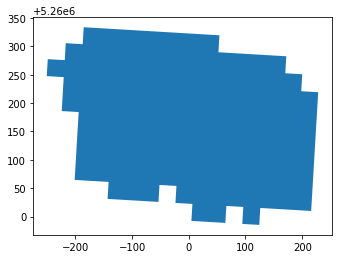

In [33]:
gdir.read_shapefile('outlines').plot();

In [34]:
# Decide on the number of plots and figure size
ns = len(sources)
x_size = 12
n_rows = -(-ns // 2)
y_size = x_size / 2 * n_rows

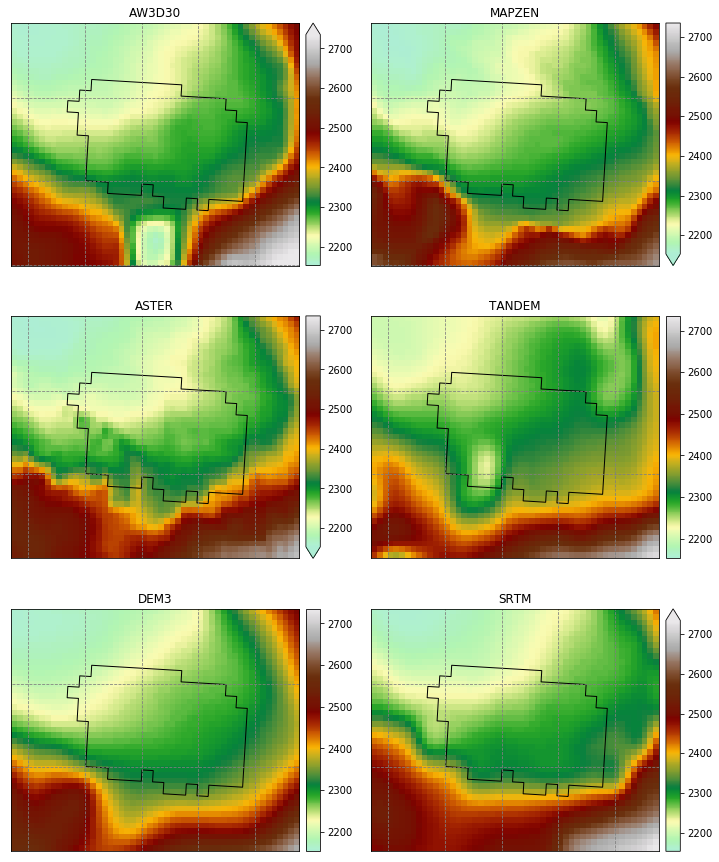

In [35]:
smap = salem.graphics.Map(gdir.grid, countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_plot_params(cmap='topo')
smap.set_lonlat_contours(add_tick_labels=False)
smap.set_plot_params(vmin=np.nanquantile([ods[s].min() for s in sources], 0.25),
                     vmax=np.nanquantile([ods[s].max() for s in sources], 0.75))

fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, 2),
                axes_pad=0.7,
                cbar_mode='each',
                cbar_location='right',
                cbar_pad=0.1
                )

for i, s in enumerate(sources):
    data = ods[s]
    smap.set_data(data)
    ax = grid[i]
    smap.visualize(ax=ax, addcbar=False, title=s)
    if np.isnan(data).all():
        grid[i].cax.remove()
        continue
    cax = grid.cbar_axes[i]
    smap.colorbarbase(cax)
    
# take care of uneven grids
if ax != grid[-1]:
    grid[-1].remove()
    grid[-1].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_topo_color.png'), dpi=150, bbox_inches='tight')